## Семинар 7: "Методы оптимизации"

ФИО:Валинуров Денис Юрьевич

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.metrics import accuracy_score
from torch.autograd import Variable
from torch import optim
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import sys
%matplotlib inline

/home/denis/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [2]:
def GD(f, df, start_point, learning_rate=0.01, max_iter=1000, eps=1e-5, is_trace=False):
    cur_iter = 1
    cur_point = np.array(start_point)
    trace = []
    while(True):
        trace.append(cur_point)
        prev_point = cur_point
        cur_point = cur_point - learning_rate * df(cur_point)
        cur_iter += 1
        if(cur_iter == max_iter or np.linalg.norm(df(cur_point)) < eps):
            break
    trace.append(cur_point)
    if(is_trace):
        return np.array(trace)
    else:
        return cur_point

In [3]:
def Momentum(f, df, start_point, gamma=0.9, learning_rate=0.01, max_iter=1000, eps=1e-5, is_trace=False):
    cur_iter = 1
    cur_point = np.array(start_point)
    trace = []
    prev_velocity = np.array([0.0, 0.0])
    while(True):
        trace.append(cur_point)
        prev_point = cur_point
        cur_velocity = gamma*prev_velocity + learning_rate*df(cur_point)
        cur_point = cur_point - cur_velocity
        cur_iter += 1
        if(cur_iter == max_iter or np.linalg.norm(df(cur_point)) < eps):
            break
    trace.append(cur_point)
    if(is_trace):
        return np.array(trace)
    else:
        return cur_point

In [4]:
def NAG(f, df, start_point, gamma=0.9, learning_rate=0.01, max_iter=1000, eps=1e-5, is_trace=False):
    cur_iter = 1
    cur_point = np.array(start_point)
    trace = []
    prev_velocity = np.array([0.0, 0.0])
    while(True):
        trace.append(cur_point)
        prev_point = cur_point
        cur_velocity = gamma*prev_velocity
        cur_velocity += learning_rate*df(cur_point - cur_velocity)
        cur_point = cur_point - cur_velocity
        cur_iter += 1
        if(cur_iter == max_iter or np.linalg.norm(df(cur_point)) < eps):
            break
    trace.append(cur_point)
    if(is_trace):
        return np.array(trace)
    else:
        return cur_point

In [5]:
def Adagrad(f, df, start_point, learning_rate=0.01, max_iter=1000, eps=1e-5, is_trace=False):
    cur_iter = 1
    cur_point = np.array(start_point)
    trace = []
    Gradsum = np.array([0.0, 0.0])
    rooteps = 1e-8
    while(True):
        trace.append(cur_point)
        prev_point = cur_point
        Gradsum += df(cur_point)**2
        cur_point = cur_point - learning_rate/np.sqrt(Gradsum + rooteps) * df(cur_point)
        cur_iter += 1
        if(cur_iter == max_iter or np.linalg.norm(df(cur_point)) < eps):
            break
    trace.append(cur_point)
    if(is_trace):
        return np.array(trace)
    else:
        return cur_point

In [6]:
def Adadelta(f, df, start_point, gamma=0.9, max_iter=1000, eps=1e-5, is_trace=False):
    cur_iter = 1
    cur_point = np.array(start_point)
    trace = []
    mean_sq_grad = np.array([0.0, 0.0])
    mean_sq_step = np.array([0.0, 0.0])
    rooteps = 1e-8
    while(True):
        trace.append(cur_point)
        prev_point = cur_point
        mean_sq_grad = gamma*mean_sq_grad + (1 - gamma)*df(cur_point)**2
        RMSg = np.sqrt(mean_sq_grad + rooteps)
        RMSstep = np.sqrt(mean_sq_step + rooteps)
        step = RMSstep/RMSg*df(cur_point)
        cur_point = cur_point - step
        mean_sq_step = gamma*mean_sq_step + (1 - gamma)*step**2
        cur_iter += 1
        if(cur_iter == max_iter or np.linalg.norm(df(cur_point)) < eps):
            break
    trace.append(cur_point)
    if(is_trace):
        return np.array(trace)
    else:
        return cur_point

In [7]:
def Adam(f, df, start_point, beta1=0.9, beta2=0.999, learning_rate=0.01, max_iter=1000, eps=1e-5, is_trace=False):
    cur_iter = 1
    cur_point = np.array(start_point)
    trace = []
    rooteps = 1e-8
    mean_grad = np.array([0.0, 0.0])
    mean_sq_grad = np.array([0.0, 0.0])
    while(True):
        trace.append(cur_point)
        prev_point = cur_point
        mean_grad = beta1*mean_grad + (1.0 - beta1)*df(cur_point)
        mean_sq_grad = beta2*mean_sq_grad + (1.0 - beta2)*df(cur_point)**2
        mean_grad = mean_grad/(1.0 - beta1**cur_iter)
        mean_sq_grad = mean_sq_grad/(1.0 - beta2**cur_iter)
        cur_point = cur_point - learning_rate/np.sqrt(mean_sq_grad + rooteps) * mean_grad
        cur_iter += 1
        if(cur_iter == max_iter or np.linalg.norm(df(cur_point)) < eps):
            break
    trace.append(cur_point)
    if(is_trace):
        return np.array(trace)
    else:
        return cur_point

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

In [8]:
f = lambda X: X[0]**2+X[1]**2
df = lambda X: np.array([2*X[0], 2*X[1]])
start_point = tuple(np.random.rand(2,1).reshape(2) * 20 - 10)

In [9]:
def apply_grads(f, df, start_point, Traces, lines_cnt=101):
    Names = ["GD", "Momentum", "NAG", "Adagrad", "Adadelta", "Adam"]
    print "start point: (%f, %f)" %(start_point[0], start_point[1])
    for i in xrange(len(Traces)):
        opt_point = Traces[i][-1:].reshape(2)
        opt_val = f(opt_point)
        print("%s\nIterations: %d\nExtremum point: (%f, %f)\nOptimal function value: %f" 
              %(Names[i], len(Traces[i]), opt_point[0], opt_point[1], opt_val))
    x = np.linspace(-10, 10, lines_cnt)
    y = np.linspace(-10, 10, lines_cnt)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in xrange(X.shape[0]):
        for j in xrange(Y.shape[0]):
            Z[i,j] = f((X[i,j], Y[i,j]))
    plt.figure(figsize=(16,20))
    for i in xrange(len(Traces)):
        trace = Traces[i]
        plt.subplot(3, 2, i+1)
        CS = plt.contour(X, Y, Z)
        plt.clabel(CS, inline=1, fontsize=10)
        plt.plot(trace[:, 0], trace[:, 1], linewidth=2.0, c='b')
        plt.title(Names[i])
    plt.show()
    return

In [10]:
Traces = [GD(f, df, start_point, is_trace=True),
          Momentum(f, df, start_point, is_trace=True),
          NAG(f, df, start_point, is_trace=True),
          Adagrad(f, df, start_point, learning_rate=1.0, is_trace=True),
          Adadelta(f, df, start_point, gamma=0.3, max_iter=10000, is_trace=True),
          Adam(f, df, start_point, beta1=0.5, beta2=0.5, max_iter=10000, is_trace=True)]

start point: (-7.407550, -4.748234)
GD
Iterations: 713
Extremum point: (-0.000004, -0.000003)
Optimal function value: 0.000000
Momentum
Iterations: 713
Extremum point: (-0.000004, -0.000003)
Optimal function value: 0.000000
NAG
Iterations: 713
Extremum point: (-0.000004, -0.000003)
Optimal function value: 0.000000
Adagrad
Iterations: 252
Extremum point: (-0.000005, -0.000000)
Optimal function value: 0.000000
Adadelta
Iterations: 3032
Extremum point: (0.000001, -0.000000)
Optimal function value: 0.000000
Adam
Iterations: 10000
Extremum point: (0.000078, 0.002246)
Optimal function value: 0.000005


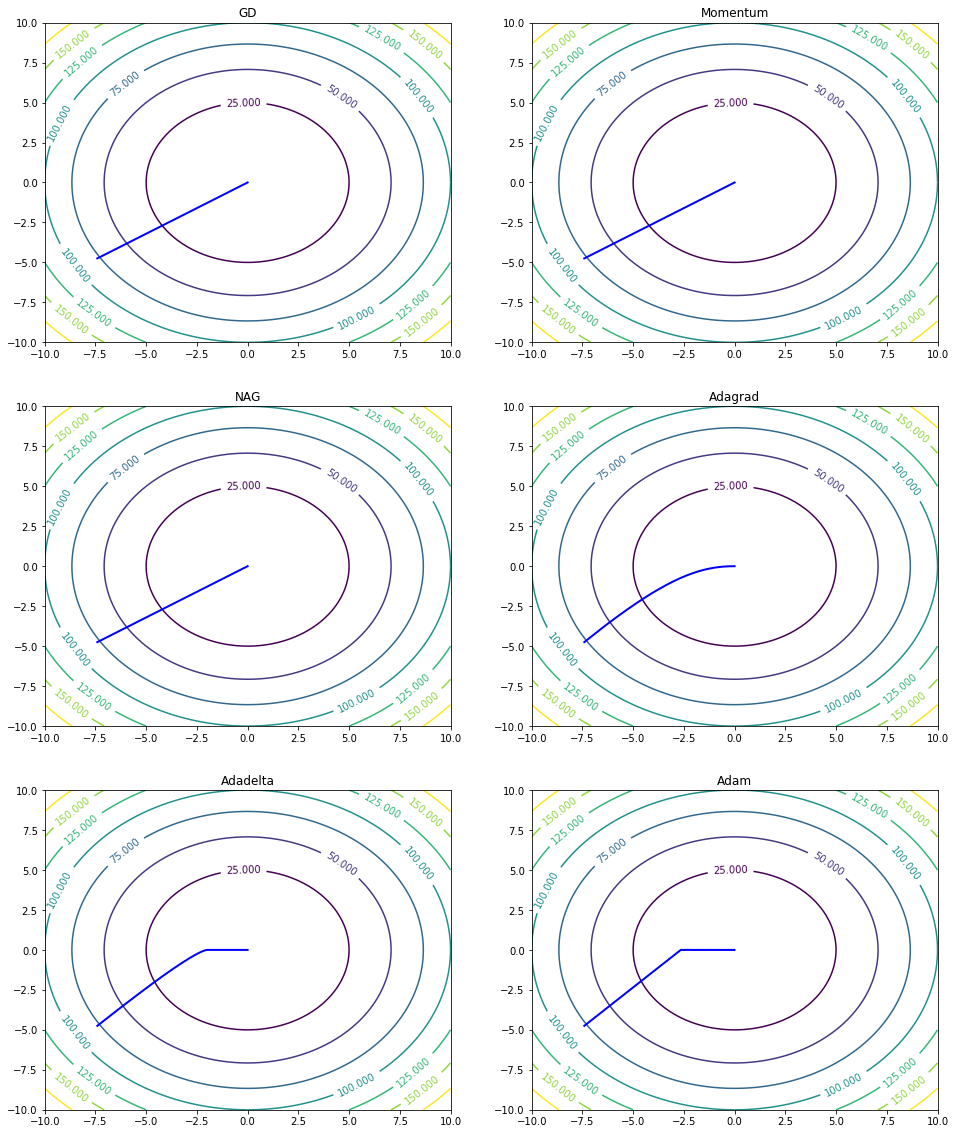

In [11]:
apply_grads(f, df, start_point, Traces)

<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

In [12]:
f = lambda X: np.sin(X[0])*X[0]**2+np.sin(X[1])*X[1]**2
df = lambda X: np.array([2*X[0]*np.sin(X[0]) + np.cos(X[0])*X[0]**2, 2*X[1]*np.sin(X[1]) + np.cos(X[1])*X[1]**2])
start_point = tuple(np.random.rand(2,1).reshape(2) * 20 - 10)

In [13]:
Traces = [GD(f, df, start_point, learning_rate=0.01, max_iter=10000, is_trace=True),
          Momentum(f, df, start_point, learning_rate=0.01, max_iter=10000, is_trace=True),
          NAG(f, df, start_point, learning_rate=0.01, max_iter=10000, is_trace=True),
          Adagrad(f, df, start_point, learning_rate=1.0, is_trace=True),
          Adadelta(f, df, start_point, gamma=0.1, max_iter=1000, is_trace=True),
          Adam(f, df, start_point, beta1=0.7, beta2=0.7, learning_rate=0.1, max_iter=50, is_trace=True)]

start point: (-1.435568, 2.195085)
GD
Iterations: 10000
Extremum point: (-2.288930, 0.003341)
Optimal function value: -3.945302
Momentum
Iterations: 10000
Extremum point: (-2.288930, 0.003341)
Optimal function value: -3.945302
NAG
Iterations: 10000
Extremum point: (-2.288930, 0.003341)
Optimal function value: -3.945302
Adagrad
Iterations: 516
Extremum point: (-2.288930, 0.001822)
Optimal function value: -3.945302
Adadelta
Iterations: 1000
Extremum point: (-2.289971, 0.216730)
Optimal function value: -3.935196
Adam
Iterations: 50
Extremum point: (-2.302483, -2.144099)
Optimal function value: -7.806659


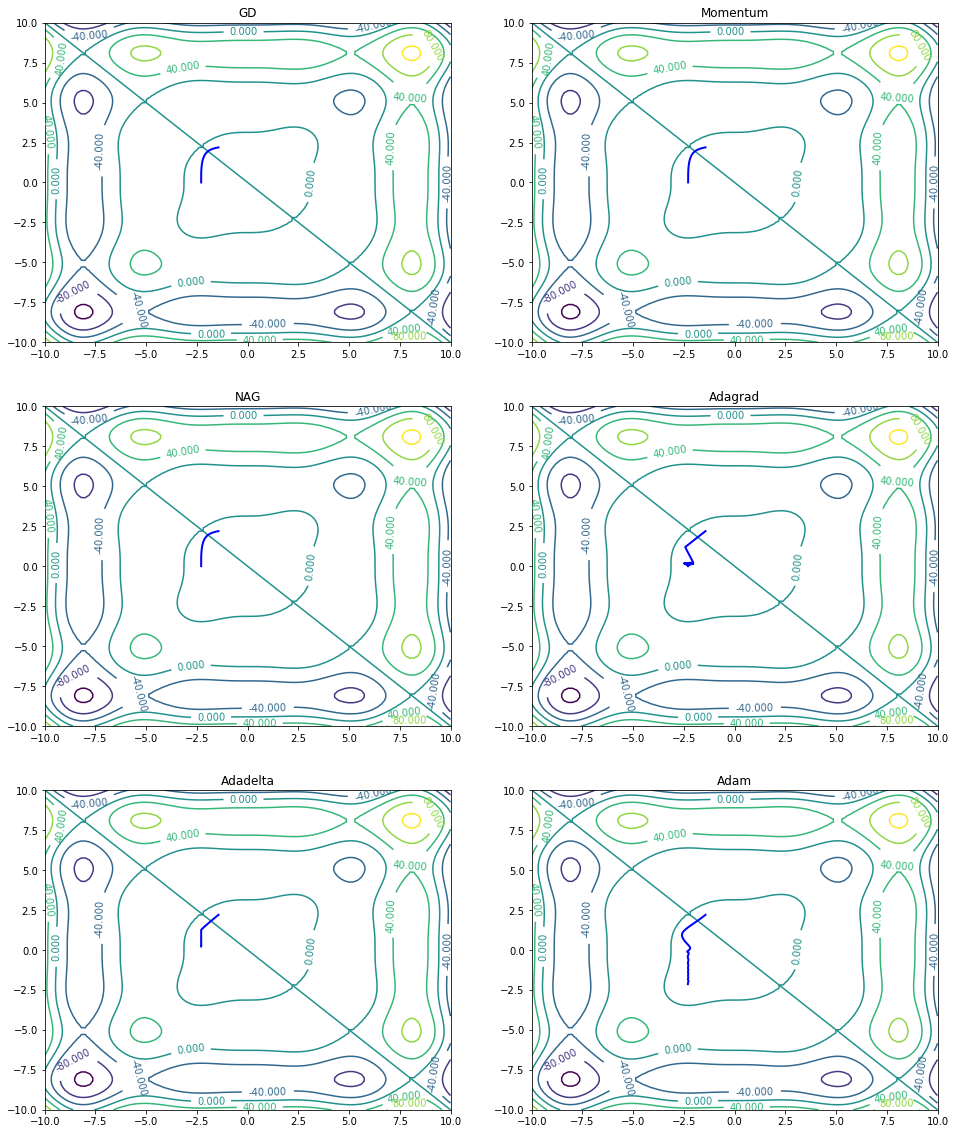

In [14]:
apply_grads(f, df, start_point, Traces)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

In [15]:
f = lambda X: np.sin(X[0]**2)*X[0]**2+np.sin(X[1]**2)*X[1]**2
df = lambda X: np.array([2*X[0]*np.sin(X[0]**2) + 2*X[0]*np.cos(X[0]**2)*X[0]**2,
                         2*X[1]*np.sin(X[1]**2) + 2*X[1]*np.cos(X[1]**2)*X[1]**2])
start_point = tuple(np.random.rand(2,1).reshape(2) * 20 - 10)

In [16]:
Traces = [GD(f, df, start_point, learning_rate=0.001, is_trace=True),
          Momentum(f, df, start_point, learning_rate=0.001, is_trace=True),
          NAG(f, df, start_point, learning_rate=0.001, is_trace=True),
          Adagrad(f, df, start_point, learning_rate=0.1, is_trace=True),
          Adadelta(f, df, start_point, gamma=0.1, max_iter=1000, is_trace=True),
          Adam(f, df, start_point, beta1=0.7, beta2=0.7, max_iter=100, is_trace=True)]

start point: (2.659670, 8.020968)
GD
Iterations: 1000
Extremum point: (2.216570, 5.288534)
Optimal function value: 3.604215
Momentum
Iterations: 1000
Extremum point: (2.216570, 5.288534)
Optimal function value: 3.604215
NAG
Iterations: 1000
Extremum point: (2.216570, 5.288534)
Optimal function value: 3.604215
Adagrad
Iterations: 94
Extremum point: (2.216570, 7.827987)
Optimal function value: -66.083686
Adadelta
Iterations: 1000
Extremum point: (2.215317, 7.826562)
Optimal function value: -66.068367
Adam
Iterations: 100
Extremum point: (2.215560, 7.826568)
Optimal function value: -66.068518


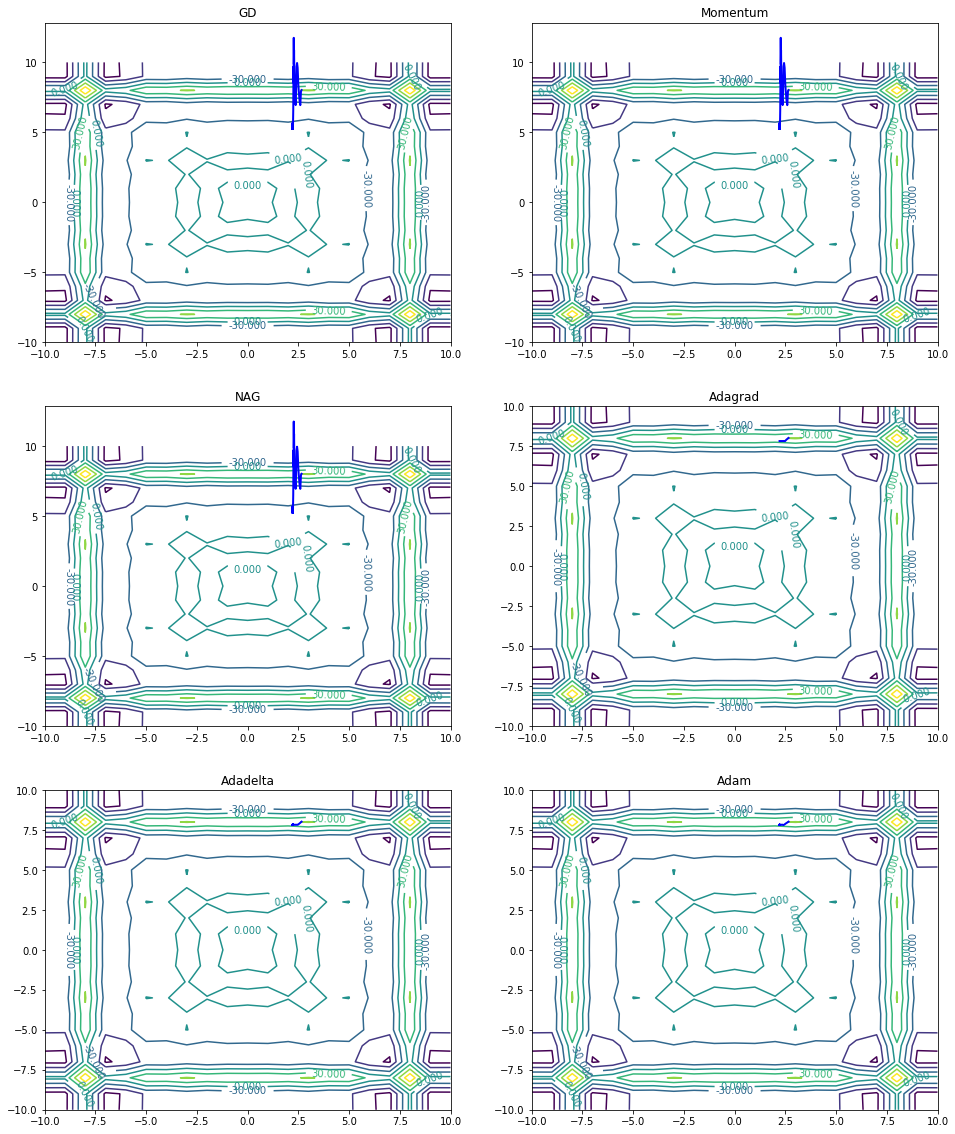

In [17]:
apply_grads(f, df, start_point, Traces, 21)

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [18]:
def train(network, epochs, learning_rate, optim):
    loss = nn.NLLLoss()
    optimizer = optim(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = Variable(X)
                y = Variable(y)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = Variable(X)
                y = Variable(y)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_epochs, label='Train')
    plt.plot(test_loss_epochs, label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_epochs, label='Train accuracy')
    plt.plot(test_accuracy_epochs, label='Test accuracy')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [19]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [20]:
class myLinNet(nn.Module):
    def __init__(self):
        super(myLinNet, self).__init__()
        self.linear_layers = nn.Sequential(nn.Linear(784, 100),
                                           nn.ELU(),
                                           nn.Linear(100, 10),
                                           nn.LogSoftmax())
        
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.linear_layers(x)
        return x

/home/denis/anaconda2/lib/python2.7/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 4... (Train/Test) NLL: 0.170/0.162	Accuracy: 0.952/0.953

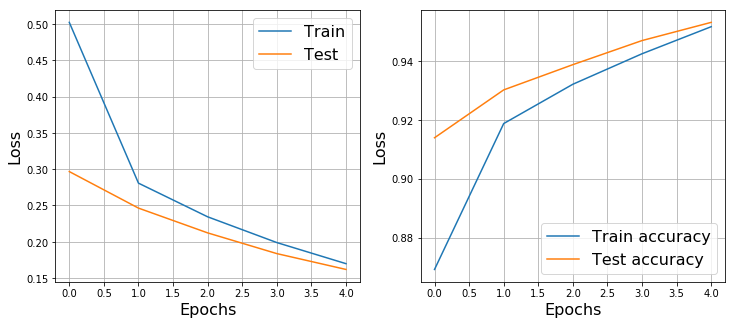

In [21]:
optim = torch.optim.Adam
network = myLinNet()
train(network, 5, 1e-4, optim)

Epoch 4... (Train/Test) NLL: 0.809/0.759	Accuracy: 0.829/0.842

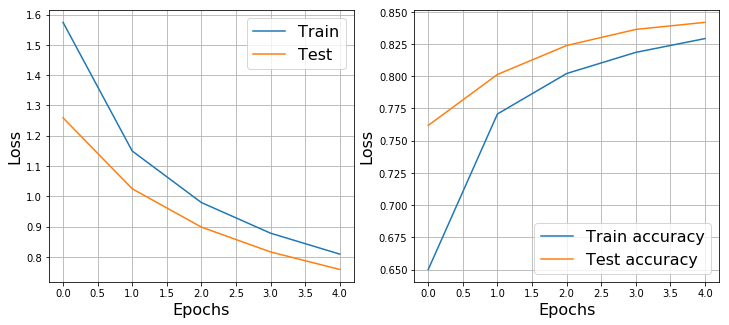

In [22]:
optim = torch.optim.Adagrad
network = myLinNet()
train(network, 5, 1e-4, optim)

Epoch 4... (Train/Test) NLL: 1.912/1.866	Accuracy: 0.512/0.541

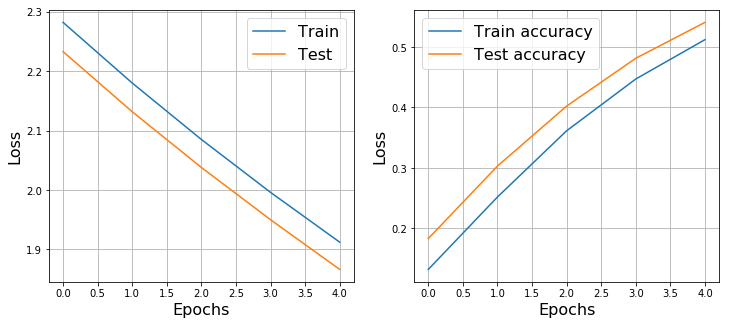

In [23]:
optim = torch.optim.Adadelta
network = myLinNet()
train(network, 5, 1e-4, optim)

Epoch 4... (Train/Test) NLL: 0.944/0.867	Accuracy: 0.804/0.821

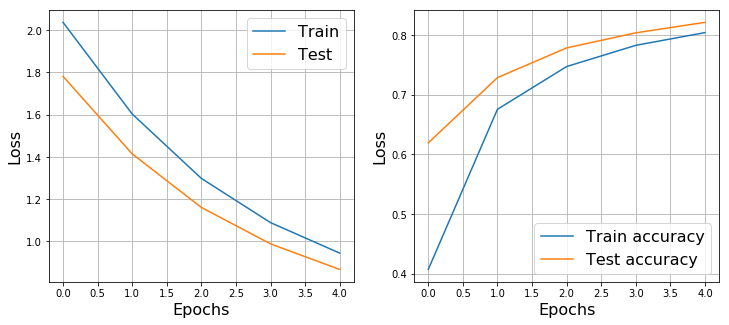

In [24]:
optim = torch.optim.SGD
network = myLinNet()
train(network, 5, 1e-4, optim)

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [27]:
image_size = 28
channels = 1
class myConvNet(nn.Module):
    def __init__(self):
        super(myConvNet, self).__init__()
        self.conv_layers = nn.Sequential(nn.Conv2d(channels, 8, 3, padding=1), 
                                         nn.ReLU(), 
                                         nn.MaxPool2d(2),
                                         nn.Conv2d(8, 16, 3, padding=1),
                                         nn.ReLU())
        self.linear_layers = nn.Sequential(nn.Linear(image_size/2*image_size/2*16, 10), nn.LogSoftmax())
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

Epoch 4... (Train/Test) NLL: 0.069/0.060	Accuracy: 0.980/0.981

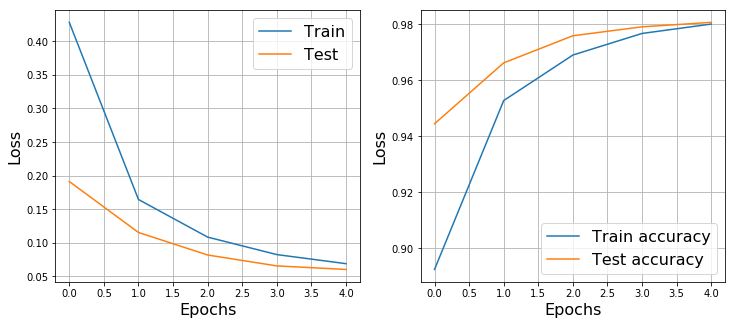

In [28]:
optim = torch.optim.Adam
network = myConvNet()
train(network, 5, 1e-4, optim)

Epoch 4... (Train/Test) NLL: 0.779/0.720	Accuracy: 0.837/0.852

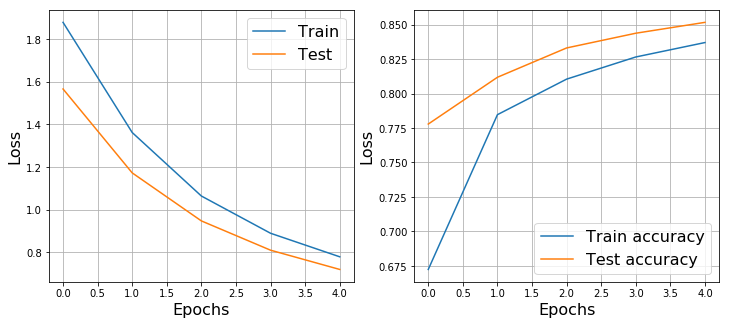

In [29]:
optim = torch.optim.Adagrad
network = myConvNet()
train(network, 5, 1e-4, optim)

Epoch 4... (Train/Test) NLL: 2.178/2.157	Accuracy: 0.462/0.510

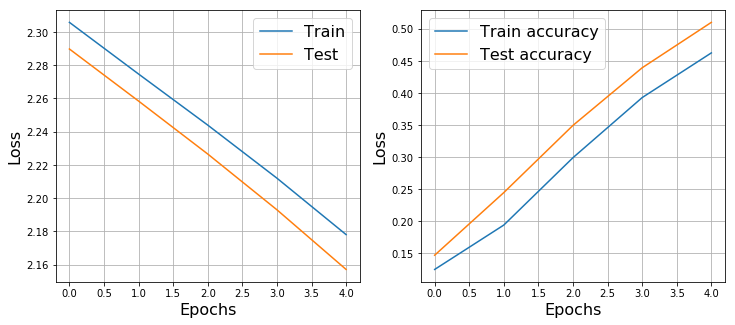

In [30]:
optim = torch.optim.Adadelta
network = myConvNet()
train(network, 5, 1e-4, optim)

Epoch 4... (Train/Test) NLL: 0.561/0.490	Accuracy: 0.853/0.871

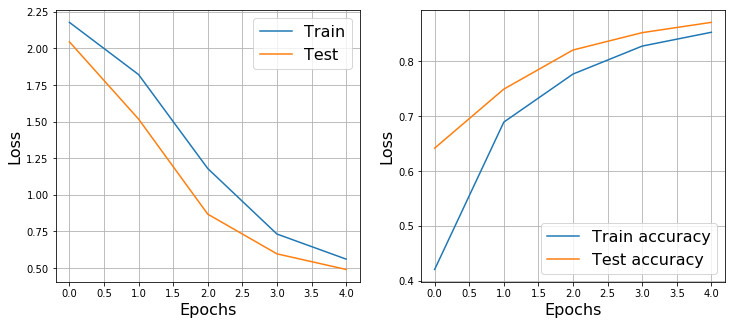

In [31]:
optim = torch.optim.SGD
network = myConvNet()
train(network, 5, 1e-4, optim)

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: